### Setup

In [ ]:
import densitysurf as ds
import numpy as np
import pandas as pd
import anndata as ad
import scipy.sparse
import scipy as sp
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.neighbors import NearestNeighbors
import seaborn as sb
import sklearn.preprocessing as p
import os
from scipy.stats import binom
import scanpy as sc
import json

To use densitysurf
1. Download the package
2. Set up a virtual environment
3. Activate the environment in the terminal
4. Install by typing pip install /path_to_package/densitysurf-0.1.0-py3-none-any.whl (or whatever the current version happens to be)

Specify path names here to streamline analysis
Give each sample a label with sample_root_names, to create output directory structure and saving output

In [ ]:
data_path = '/data_path/'
data_fn = ['D04319C6.cell.cluster.h5ad', 'C04597D6.cell.cluster.h5ad']
sample_root_names = ['D04319C6', 'C04597D6']

### Choose columns

This is an example STOMICS import workflow. Please don't use it as an example, as it is for an older version of STOMICS alignment output. 
You will have to create an import workflow specific to your data. The python package scanpy is a good place to start. 

Visualising distribution of gene intensities

In [ ]:
C = []
for i in range(0, len(data_fn)):
    data = h5py.File(data_path + data_fn[i], 'r')
    data = sp.sparse.csr_matrix((data['raw']['X']['data'], data['raw']['X']['indices'], data['raw']['X']['indptr']), shape = data['raw']['X'].attrs['shape'])
    data = pd.DataFrame.sparse.from_spmatrix(data)
    cs = np.sum(data, 0)/data.shape[0] # normalised column sums of raw data
    C.append(cs)


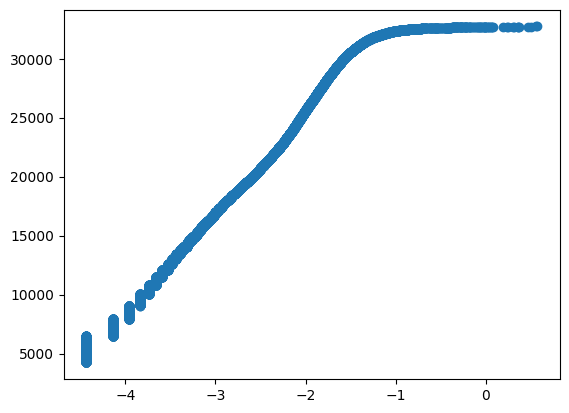

In [ ]:
i = 1
plt.scatter(np.sort(np.log10(C[i])), range(0, len(C[i])))

In [ ]:
# getting gene names
B = [ad.io.read_h5ad(data_path + x).var.index for x in data_fn]

In [ ]:
# initialise empty list, to store column (gene) intensities
C = []
for i in range(0, len(data_fn)):
    #####
    # stomics import
    data = h5py.File(data_path + data_fn[i], 'r')
    data = sp.sparse.csr_matrix((data['raw']['X']['data'], data['raw']['X']['indices'], data['raw']['X']['indptr']), shape = data['raw']['X'].attrs['shape'])
    data = pd.DataFrame.sparse.from_spmatrix(data)
    data.columns = B[i]
    ######
    
    ######
    # taking the top 2.5 log decades (as defined by column sums of raw data)
    cs = np.sum(data, 0)/data.shape[0]
    w = 10**(np.log10(np.max(cs)) - 2.5) # dynamic range of 2.5 log decades
    C.append(data.loc[:, cs > w].columns)

# Take the union of gene names over the expression matrices
C = list(set.union(*map(set, C)))

# Top level analysis of each sample

1) import h5 files
2) create directory structure
3) ds.Transform and goodness_of_fit
4) save results
5) inspect results to choose number of components K
6) Finalise analysis with cell and gene clustering to obtain exemplar cells/genes, and biomarker specificity network

In [ ]:
# specify the path where to save all output, and create a directory structure
top_level_path = '/output_path/'
ds.multi_sample_directory_structure(top_level_path, sample_root_names)

In [ ]:
for i in range(0, len(sample_root_names)):
    data = h5py.File(data_path + data_fn[i], 'r')
    data = sp.sparse.csr_matrix((data['raw']['X']['data'], data['raw']['X']['indices'], data['raw']['X']['indptr']), shape = data['raw']['X'].attrs['shape'])
    data = pd.DataFrame.sparse.from_spmatrix(data)
    data.columns = B[i]
    data = data.loc[:, C]
    T = ds.Transform(data, ncomps = 200, n_oversamples = 200)
    T.pickle_save(path = os.path.join(top_level_path, sample_root_names[i], 'transform/'))
    cell_clus = []
    gene_clus = []
    for j in range(5, 200, 5): # vector of number of components over which to test clustering
        C_cell = ds.Cluster(T, ncomp_clus=j, mode = 'cells')
        C_gene = ds.Cluster(T, ncomp_clus=j, mode = 'genes')
        cell_clus.append(C_cell.membership_all['subcluster'])
        gene_clus.append(C_gene.membership_all['subcluster'])
    pd.DataFrame(cell_clus).to_csv(os.path.join(top_level_path, sample_root_names[i], 'cells/ncomp_clus.txt.gz'))
    pd.DataFrame(gene_clus).to_csv(os.path.join(top_level_path, sample_root_names[i], 'genes/ncomp_clus.txt.gz'))

#### Select ncomp

The current method is to choose the number of components K according to the minimum number of clusters
This method is still under development and not expected to work in all scenarios. It appears to work well for single cell transcriptomics and other biological omics data, where a high modularity can be expected. 

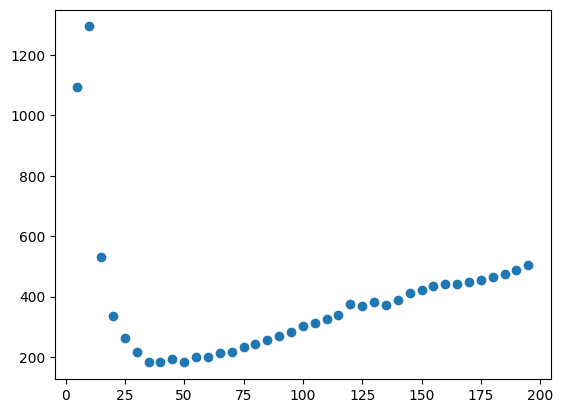

In [ ]:
i = 0
cell_clus = pd.read_csv(os.path.join(top_level_path, sample_root_names[i], 'cells/ncomp_clus.txt.gz'))
cell_clus.drop(cell_clus.columns[0], axis = 1, inplace=True)
plt.scatter(range(5, 200, 5), cell_clus.max(axis = 1))

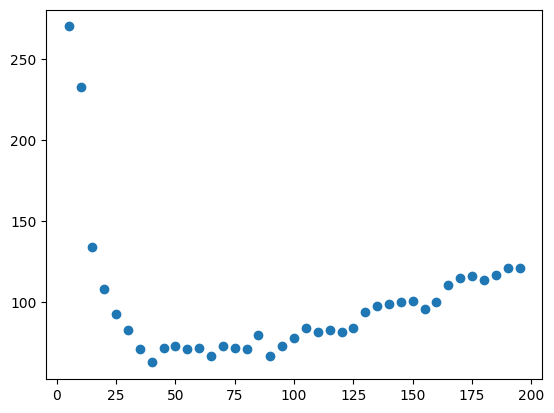

In [ ]:
i = 0
gene_clus = pd.read_csv(os.path.join(top_level_path, sample_root_names[i], 'genes/ncomp_clus.txt.gz'))
gene_clus.drop(cell_clus.columns[0], axis = 1, inplace=True)
plt.scatter(range(5, 200, 5), gene_clus.max(axis = 1))

In [ ]:
# choose number of components K and finalise clustering, biomarker specificity network

K = 50

for i in range(0, len(sample_root_names)):
    T = ds.Transform.pickle_load(os.path.join(top_level_path, sample_root_names[i] +'/transform/'))
    T.umap(ncomp_cell=K, ncomp_gene=K)
    T.goodness_of_fit(min_percent=list([1, 20, 40, 60, 80]))
    T.save(path = os.path.join(top_level_path, sample_root_names[i], 'transform/'))
    C_cell = ds.Cluster(T, mode = 'cells', ncomp_clus=K)
    C_gene = ds.Cluster(T, mode = 'genes', ncomp_clus=K)
    C_cell.local_goodness_of_fit(T)
    C_gene.local_goodness_of_fit(T)
    C_cell.save(path = os.path.join(top_level_path, sample_root_names[i], 'cells/'))
    C_gene.save(path = os.path.join(top_level_path, sample_root_names[i], 'genes/'))
    S = ds.SpecificityNetwork(T, C_cell, C_gene)
    S.save(path = os.path.join(top_level_path, sample_root_names[i], 'specificity_network/'))